In [163]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline

sns.set_style('whitegrid')

In [284]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [165]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


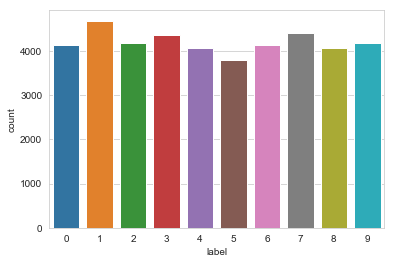

In [166]:
#可以看出各种类别的数量大致差不多
sns.countplot(train['label'])

In [167]:
#使用pytorch进行预测,导入各种库
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim

from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset

In [168]:
#首先设置模型是否使用cuda加速
use_cuda = torch.cuda.is_available()

加载图像后，我们经常需要对图片进行剪裁，随机旋转等操作，这些操作可以使用`torchivision.transform`实现。首先我们使用`transforms.Compose()`，来构造一个对图片进行预处理的操作序列，因为这个数据集来自于Kaggle,已经是一维向量数据，我们先将其转换为PIL图像，再使用`ToTensor`将图像转换为张量数据，在这过程中灰阶范围会自动从0-255变为0-1，然后使用`Normalize`将数据进行均值为0.5，标准差为1的标准化。这里需要注意，虽然MNIST中图像都是灰度图像，通道数均为1，但是仍要传入tuple。

In [169]:
#这里我们需要重新构建dataset，以符合pytorch的加载标准
trans = transforms.Compose([transforms.ToPILImage(),
                            transforms.ToTensor(),
                            transforms.Normalize((0.5,),(0.5,))])

n_pixels = 784

class MNIST_data(Dataset):
    """MINST DATA SET"""
    
    def __init__(self,file_path,transform = transforms.Compose([transforms.ToPILImage(),
                            transforms.ToTensor(),
                            transforms.Normalize((0.5,),(0.5,))])):
        df = pd.read_csv(file_path)
        
        if len(df.columns) == n_pixels:
            #检查读入的数据集列数量，如果等于图片像素数量28*28，说明是test集
            self.X = df.values.reshape((-1,28,28)).astype(np.uint8)[:,:,:,None]
            self.y = None
        else:
            #检查读入的数据集列数量，如果不等于图片像素数量28*28，说明是train集
            self.X = df.iloc[:,1:].values.reshape((-1,28,28)).astype(np.uint8)[:,:,:,None]
            self.y = torch.from_numpy(df.iloc[:,0].values)
            #将array转换为tensor
            
        self.transform = transform
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        if self.y is not None:
            return self.transform(self.X[idx]), self.y[idx]
        else:
            return self.transform(self.X[idx])
    

In [316]:
# #由于数据来源于Kaggle，所以这里我们使用sklearn中的分割器将train数据分离为两部分

# from sklearn.model_selection import train_test_split
# X_train,X_test,y_train,y_test = train_test_split(train.drop('label',axis = 1),
#                                                  train['label'],
#                                                  test_size = 0.2,
#                                                 random_state = 0)
batch_size = 100

#这里加载数据集
#将训练集可以随机旋转一下，测试集不做调整，只是标准化

train_dataset = MNIST_data('train.csv', 
                           transform = transforms.Compose(
                            [transforms.ToPILImage(),
                             transforms.RandomRotation(20),
                             transforms.ToTensor(),
                             transforms.Normalize(mean=(0.5,), std=(0.5,))]))

test_dataset = MNIST_data('test.csv')

#Pytorch中使用loader来向网络提供数据，这里搭建两个数据加载器

train_loader = torch.utils.data.DataLoader(
                  dataset = train_dataset,
                  batch_size = batch_size,
                  shuffle = True)

test_loader = torch.utils.data.DataLoader(
                  dataset = test_dataset,
                  batch_size = batch_size,
                  shuffle = True)



In [171]:
print(f'Total Training Batch Number is {len(train_loader)}')
print(f'Total Test Batch Number is {len(test_loader)}')

Total Training Batch Number is 420
Total Test Batch Number is 280


现在进行网络构建，构建两个网络,分别使用两个网络预测，最后对比效率：
 - 简单的MLPNet(Multiple Layer Perceptron多层感知机)
 - 传统的LeNet5网络

In [195]:
#在进行网络构建时，
#主要通过torch.nn包中的已经实现好的卷积层、池化层等进行搭建。例如下面的代码展示了一个具有两个全连接
#隐藏层的MLP网络

class MLPNet(nn.Module):
    def __init__(self):
        super(MLPNet,self).__init__()
        self.fc1 = nn.Linear(28*28,500)
        self.fc2 = nn.Linear(500,256)
        self.fc3 = nn.Linear(256,10)
    
    def forward(self,x):
        x = x.view(-1,28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def name(self):
        return 'MLP'
    
#这里再构建一个LeNet5网络，LeNet5网络是经典的识别手写库的网络,
#LeNet5 这个网络虽然很小，但是它包含了深度学习的基本模块：卷积层，池化层，全链接层。是其他深度学习模型的基础

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    def name(self):
        return 'LeNet'
    
    

In [308]:
#先实例一个MLP网络
model1 = MLPNet()
#定义优化器，使用随机梯度下降，学习速率0.1，动量设置为0.9
optimizer = optim.SGD(model.parameters(),lr=0.01,momentum=0.9)

#定义惩罚函数，使用交叉熵
criterion = nn.CrossEntropyLoss()

if use_cuda:
    model1 = model.cuda()

#定义训练函数
def train(model,epoch,train_loader,
          criterion = criterion,optimizer = optimizer):
    for e in range(epoch):
        for batch_idx,(inputs,labels) in enumerate(train_loader):
            inputs, labels = Variable(inputs), Variable(labels)
            if use_cuda:
                inputs = inputs.cuda()
                labels = labels.cuda()

            optimizer.zero_grad() #梯度清零
            
            outputs = model(inputs)#正向传播
            
            loss = criterion(outputs,labels)#求得误差

            loss.backward()#反向传播
            optimizer.step()#参数优化

            if (batch_idx + 1)%100 == 0:   #每一百个batch打印一次结果
                print('Traing Epoch : {} [{}/{} ({:.0f}%)]\tLoss:{:.6f}'.format(
                    e + 1,
                    (batch_idx + 1) * len(inputs),
                    len(train_loader.dataset),
                    100 * (batch_idx + 1) / len(train_loader),
                    loss.data.item()))
            
            


In [279]:
#定义测试函数

def evaluate(model,data_loader):
    correct = 0
    total = 0 
    loss = 0
    with torch.no_grad():# 使用验证集时关闭梯度计算
        for inputs,labels in data_loader:
            if use_cuda :
                inputs = inputs.cuda()
                labels = labels.cuda()
                model.cuda()
            
            outputs = model(inputs)
            predicted = torch.max(outputs.data,1)[1]
            # torch.max返回输出结果中，按dim=1行排列的每一行最大数据及他的索引，丢弃数据，保留索引
            loss += F.cross_entropy(outputs, target, reduction = 'sum').data.item()
            #每此批处理记录交叉熵
           
           
            correct += (predicted == labels).sum().item()
            
           #将预测及标签两相同大小张量逐一比较各相同元素的个数
    
        print('The Accuracy is {}/{} ({:.4f}%),The Average Loss is {:.3f}'.format(
            correct,
            len(data_loader.dataset),
            100 * correct/len(data_loader.dataset),
            loss/len(data_loader.dataset)
            ))
                

In [265]:
#定义预测函数

def predict(model,dataloader):
    test_pred = torch.LongTensor()#建造一个列表来存储每一批的预测结果
    with torch.no_grad():
        for inputs in dataloader:
            if use_cuda:
                inputs = inputs.cuda()
                test_pred.cuda()
            outputs = model(inputs)
            predicted = torch.max(outputs.cpu().data,1)[1]
            
            test_pred = torch.cat((test_pred,predicted),dim = 0)
            #每一批的预测结果加到列表后方，同一行
            
    return test_pred
    
            
            

In [281]:
#进行1号模型MLP网络的测试和训练

train(model1,epoch = 1)
evaluate(model1,train_loader)
    

Traing Epoch : 1 [10000/42000 (24%)]	Loss:0.016520
Traing Epoch : 1 [20000/42000 (48%)]	Loss:0.019866
Traing Epoch : 1 [30000/42000 (71%)]	Loss:0.018730
Traing Epoch : 1 [40000/42000 (95%)]	Loss:0.024125
The Accuracy is 41783/42000 (99.4833%),The Average Loss is 17.379


In [266]:
test_predict = predict(model1,test_loader)

In [269]:
test_predict.shape

torch.Size([28000])

In [273]:
submission_MLP = pd.DataFrame({
    'ImageId':np.arange(1,len(test_loader.dataset)+1),
    'Label':test_predict
})

submission_MLP.to_csv('submission_MLP.csv',index = False)

# 现在使用LeNet试试

In [314]:
#现在使用LeNet
model2 = LeNet()
optimizer = optim.SGD(model.parameters(),lr=0.01,momentum=0.9)
criterion = nn.CrossEntropyLoss()
if use_cuda:
    model2 = model.cuda()

In [318]:
train(model2,1,train_loader)
evaluate(model2,train_loader)

Traing Epoch : 1 [10000/42000 (24%)]	Loss:0.014518
Traing Epoch : 1 [20000/42000 (48%)]	Loss:0.061000
Traing Epoch : 1 [30000/42000 (71%)]	Loss:0.028702
Traing Epoch : 1 [40000/42000 (95%)]	Loss:0.029659
The Accuracy is 41798/42000 (99.5190%),The Average Loss is 18.371


In [280]:
test_predict = predict(model2,test_loader)
submission_LeNet = pd.DataFrame({
    'ImageId':np.arange(1,len(test_loader.dataset)+1),
    'Label':test_predict
})

submission_LeNet.to_csv('submission_LeNet.csv',index = False)

两个网络在训练集上都表现非常好，达到了99%的准确率，但是在测试集上表现非常不好。所以设计CV,看看问题出在什么地方

In [285]:
#使用SKLEARN留出法分割原训练集
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(train.drop('label',axis = 1),
                                                 train['label'],
                                                 test_size = 0.2,
                                                random_state = 0)

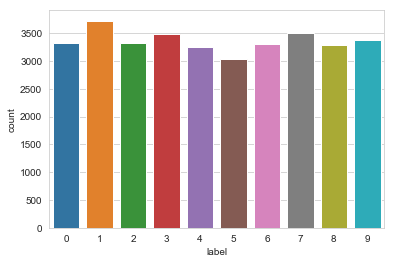

In [300]:
sns.countplot(y_train)
#可以看出是分层分割的

In [302]:
#转化为CSV文件，方便pytorch加载器读取
train_cv = pd.concat((y_train,X_train),axis = 1)
test_cv = pd.concat((y_test,X_test),axis = 1)

train_cv.to_csv('train_cv.csv',index = False)
test_cv.to_csv('test_cv.csv',index = False)

In [304]:
train_dataset_cv = MNIST_data('train_cv.csv', 
                           transform = transforms.Compose(
                            [transforms.ToPILImage(),
                             transforms.RandomRotation(20),
                             transforms.ToTensor(),
                             transforms.Normalize(mean=(0.5,), std=(0.5,))]))

test_dataset_cv = MNIST_data('test_cv.csv')

In [305]:
train_cv_loader = torch.utils.data.DataLoader(
                  dataset = train_dataset_cv,
                  batch_size = batch_size,
                  shuffle = True)

test_cv_loader = torch.utils.data.DataLoader(
                  dataset = test_dataset_cv,
                  batch_size = batch_size,
                  shuffle = True)

In [307]:
mlp_cv = MLPNet()
optimizer = optim.SGD(model.parameters(),lr=0.01,momentum=0.9)
criterion = nn.CrossEntropyLoss()
if use_cuda:
    mlp_cv = model.cuda()

In [311]:
train(mlp_cv,1,train_cv_loader)
evaluate(mlp_cv,test_cv_loader)

Traing Epoch : 1 [10000/33600 (30%)]	Loss:0.004718
Traing Epoch : 1 [20000/33600 (60%)]	Loss:0.012898
Traing Epoch : 1 [30000/33600 (89%)]	Loss:0.001700
The Accuracy is 8377/8400 (99.7262%),The Average Loss is 18.586


# 真特么奇了怪了，CV准确率都那么高，为啥测试集那么低？编号出问题了吧

# 发现问题，是因为之前的testloader中shuffle开了，顺序打乱了，最终当然编号就出问题了，关闭shuffle，重新使用LeNet预测一次

In [319]:
test_loader = torch.utils.data.DataLoader(
                  dataset = test_dataset,
                  batch_size = batch_size,
                  shuffle = False)

In [320]:
test_predict = predict(model2,test_loader)
submission_LeNet = pd.DataFrame({
    'ImageId':np.arange(1,len(test_loader.dataset)+1),
    'Label':test_predict
})

submission_LeNet.to_csv('submission_LeNet.csv',index = False)

In [322]:
# 终于在测试集上达到了99.2%的准确率